In [2]:
from Dataset import VideoDataset
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from Loss import FocalLoss
from torchvision import models
import albumentations as A
from Model import CNNLSTMAttention
from sklearn.metrics import confusion_matrix
from Dataset import create_data_loaders,preprocessing,transform_aug
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
plt.rcParams["font.family"] = "Times New Roman"


In [5]:
input_video_path = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train\0_2024-12-04-18-30-00_592_L.mp4'
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print("Error: Cannot open video file.")
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

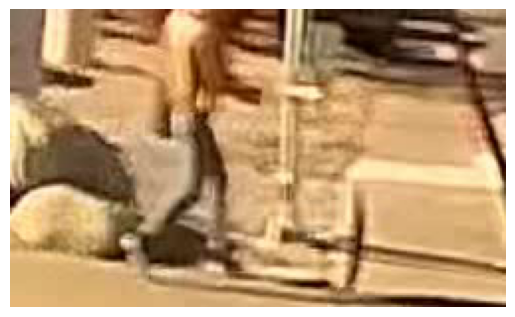

In [3]:
# plot one frame
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
# hide the x and y axis
plt.axis('off')
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\single_frame.png')
plt.show()

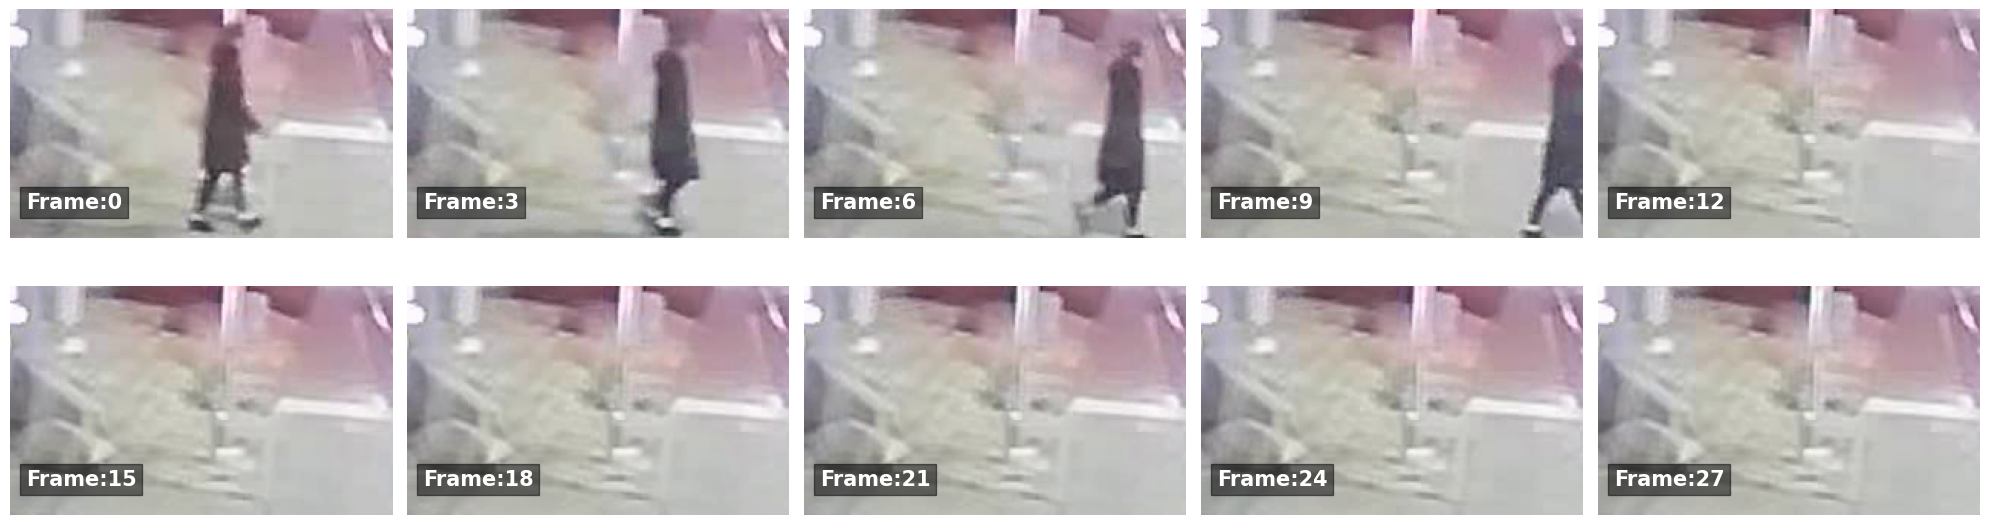

In [6]:
# plot all frames in 2 x 5 grid, with 3 frame step
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(cv2.cvtColor(frames[i * 3], cv2.COLOR_BGR2RGB))
    ax.axis('off')
    # annotate frame number in bottom of each frame
    ax.annotate(f'Frame:{i*3}', (10, 130), color='white', weight='bold', fontsize=15,
                bbox=dict(facecolor='black', alpha=0.5))
# make row 1 and 2 closer
plt.subplots_adjust(hspace=-0.7)
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\frames_notpushed.png',dpi = 300)
plt.tight_layout()
plt.show()

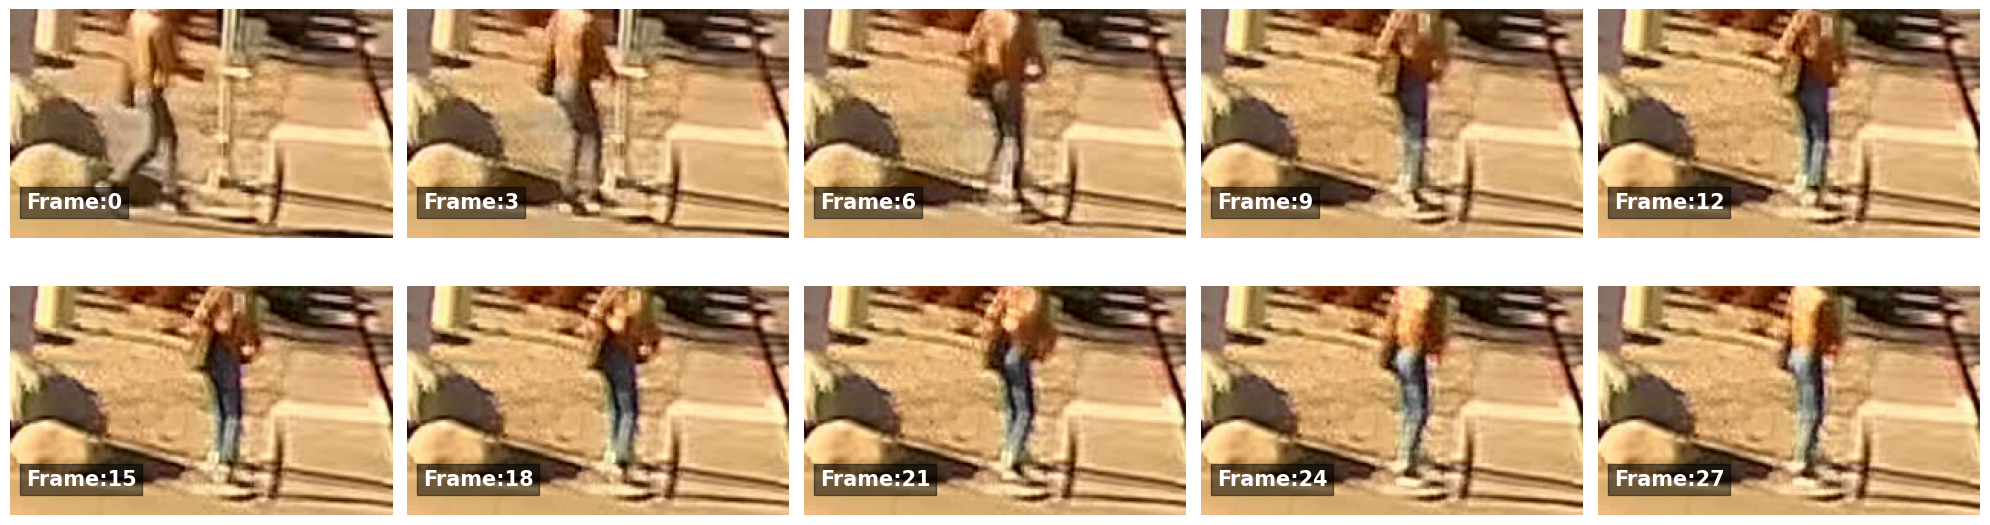

In [4]:
# plot all frames in 2 x 5 grid, with 3 frame step
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(cv2.cvtColor(frames[i * 3], cv2.COLOR_BGR2RGB))
    ax.axis('off')
    # annotate frame number in bottom of each frame
    ax.annotate(f'Frame:{i*3}', (10, 130), color='white', weight='bold', fontsize=15,
                bbox=dict(facecolor='black', alpha=0.5))
# make row 1 and 2 closer
plt.subplots_adjust(hspace=-0.7)
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\frames_pushed.png',dpi = 300)
plt.tight_layout()

plt.show()

In [51]:
# Custom Transform for Normalization
def preprocessing(frames):
    """ Normalize frames (batch_size, seq_len, h, w, c) """
    # to tensor
    frames = torch.tensor(frames)
    frames = frames / 255.0  # Scale pixel values to [0, 1]
    mean = torch.tensor([0.485, 0.456, 0.406])  # Imagenet mean for RGB
    std = torch.tensor([0.229, 0.224, 0.225])  # Imagenet std for RGB
    frames = (frames - mean) / std  # Normalize
    frames = frames.to(torch.float32).permute(0,3,1,2)
    # frames = torch.nn.functional.interpolate(frames.permute(0,3,1,2), size=224, mode = 'bilinear', align_corners=False)
    return frames

In [50]:
model_path = r"D:\LiDAR_Data\2ndPHB\Video\left_signal_0108_BCE\model\best_model.pth" 
model = CNNLSTMAttention(cnn_output_dim=128,
    lstm_hidden_dim=128,
    lstm_layers=1).to(device)
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()

CNNLSTMAttention(
  (cnn): CNNFeatureExtractor(
    (cnn): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten(start_dim=1, end_dim=-1)
      (8): Linear(in_features=73408, out_features=128, bias=True)
      (9): ReLU()
    )
  )
  (lstm): LSTM(128, 128, batch_first=True)
  (attention): Attention(
    (attention_weights): Linear(in_features=128, out_features=1, bias=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [52]:
train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train'
val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\val'
val_dataset = VideoDataset(val_dir, preprocess=preprocessing)

In [101]:
activation_ind = []
for i in range(0, len(val_dataset)):
    frames,label,location = val_dataset[i]
    if label == 1:
        activation_ind.append(i)
    # frames = frames.unsqueeze(0).to(device)
    # output,attention_weights = model(frames)

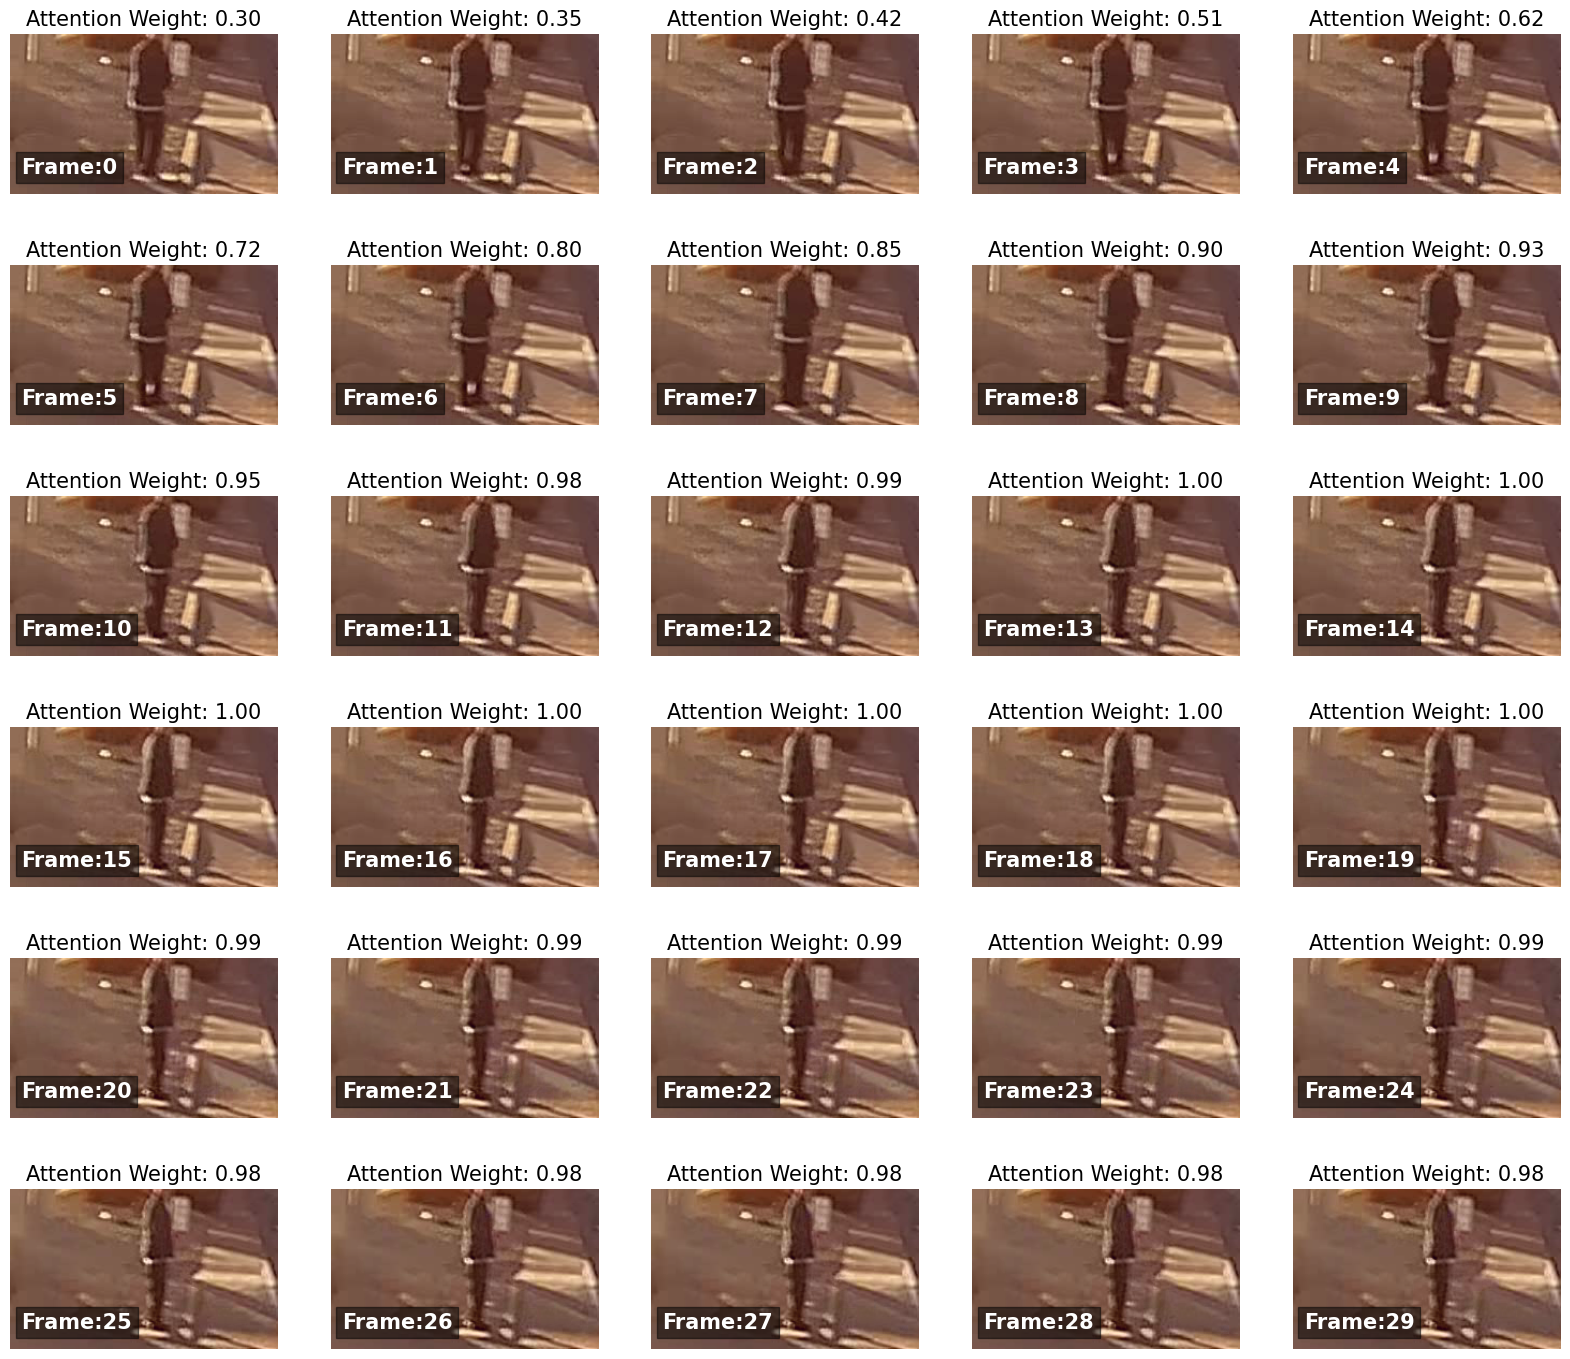

In [219]:
i = activation_ind[560]
frames,label,location = val_dataset[i]
frames = frames.unsqueeze(0).to(device)
output,attention_weights = model(frames)
attention_weights_numpy = attention_weights.squeeze(0).cpu().detach().numpy().flatten()
# normalize attention weights
attention_weights_numpy = attention_weights_numpy / attention_weights_numpy.max()
frames_numpy = frames.squeeze(0).permute(0,2,3,1).cpu().detach().numpy()
# plot frames with attention weights
fig, axs = plt.subplots(6, 5, figsize=(20, 20))
for i, ax in enumerate(axs.flat):
    temp = frames_numpy[i]
    # normalize temp to [0, 1]
    temp = (temp - temp.min()) / (temp.max() - temp.min())
    ax.imshow(temp)
    ax.axis('off')
    ax.annotate(f'Frame:{i}', (10, 130), color='white', weight='bold', fontsize=15,
                bbox=dict(facecolor='black', alpha=0.5))
    ax.set_title(f'Attention Weight: {attention_weights_numpy[i]:.2f}', fontsize=15)
plt.subplots_adjust(hspace=-0.4)
plt.show()

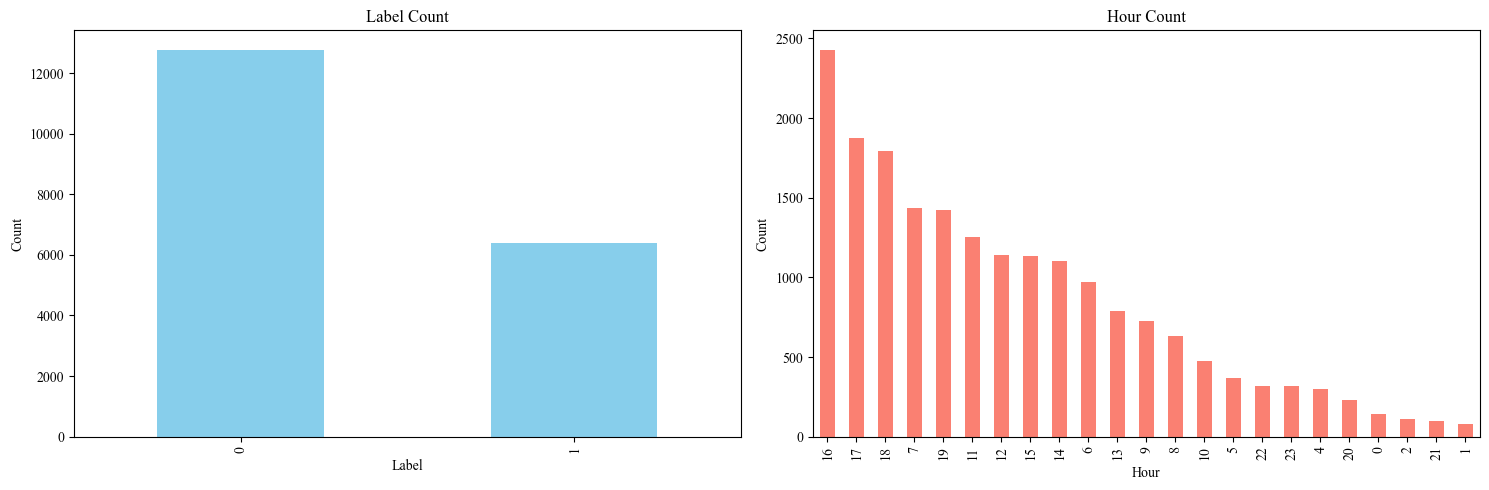

In [4]:
data_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\train'
data_list = os.listdir(data_dir)
labels = []
hours = []
for data in data_list:
    label = data.split('_')[0]
    labels.append(label)
    date = data.split('_')[1]
    # convert hour to datetime
    # date = datetime.strptime(date, '%Y-%m-%d-%H-%M-%S')
    hours.append(int(date[11:13]))
# count number of labels
label_count = pd.Series(labels).value_counts()
# count number of hours
hour_count = pd.Series(hours).value_counts()
# plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
label_count.plot(kind='bar', ax=axs[0], color='skyblue')
axs[0].set_title('Label Count')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Count')
hour_count.plot(kind='bar', ax=axs[1], color='salmon')
axs[1].set_title('Hour Count')
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

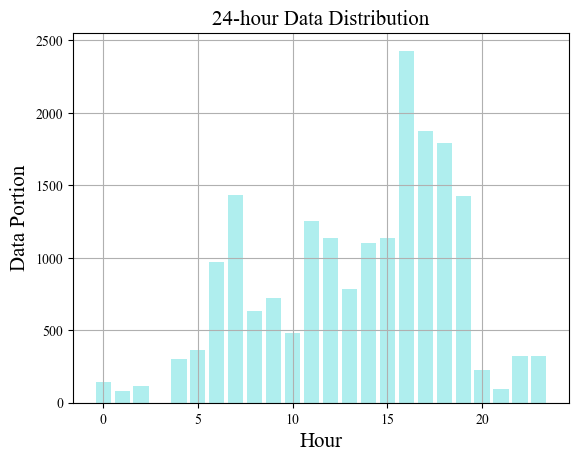

In [7]:
fig, ax = plt.subplots()
ax.bar(hour_count.index, hour_count.values, color = 'paleturquoise')
ax.grid()
ax.set_xlabel('Hour',fontsize = 15)
ax.set_ylabel('Data Portion',fontsize = 15)
ax.set_title('24-hour Data Distribution',fontsize = 15)
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\hour_count.png')
plt.show()

In [8]:
# calcualte the night time data portion (6pm to 6am)
night_time = hour_count[18:].sum() + hour_count[:6].sum()
night_time / hour_count.sum()



0.5674236491777603

In [9]:
day_time = hour_count[6:18].sum()
day_time / hour_count.sum()

0.4325763508222396

In [ ]:
frame_width,frame_height = 250,150
x,y = 450,780
pt1_L = (x, y)
pt2_L = (450+frame_width, 780+frame_height)
x,y = 1450,800
pt1_R = (x, y)
pt2_R = (x+frame_width, y+frame_height)
ROI_L, ROI_R = [pt1_L, pt2_L], [pt1_R, pt2_R]
model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0111_BCE\model\best_model.pth" 
model = CNNLSTMAttention(cnn_output_dim=128,
    lstm_hidden_dim=128,
    lstm_layers=1).to(device)
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()

In [ ]:

train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\train'
val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\test'
train_loader, val_loader = create_data_loaders(train_dir, val_dir, batch_size=2, preprocess=preprocessing, augmentation=transform_aug)
model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0111_BCE\model\best_model.pth"
# model = ResNetLSTMWithAttention().to(device)
cnn_output_dim=64
lstm_hidden_dim=64
lstm_layers=1
model = CNNLSTMAttention(cnn_output_dim=cnn_output_dim,lstm_hidden_dim=lstm_hidden_dim,lstm_layers=lstm_layers).to(device)
model.load_state_dict(torch.load(model_path,weights_only=True))
# calculate the confusion matrix
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    with tqdm(total=len(val_loader), desc="Validation") as pbar:
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs, attention_weights = model(inputs)
            # outputs = model(inputs)
            outputs = torch.flatten(outputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())
            pbar.update(1)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
confidence_thresholds = np.arange(0.1, 0.9, 0.1)
precision_scores = []
recall_scores = []
F1_scores = []

for threshold in confidence_thresholds:
    y_pred_thresholded = (y_pred > threshold).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred_thresholded)
    precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
    recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    F1 = 2 * precision * recall / (precision + recall)

    precision_scores.append(precision)
    recall_scores.append(recall)
    F1_scores.append(F1)


TP: 947, FP: 6, FN: 34, TN: 2067


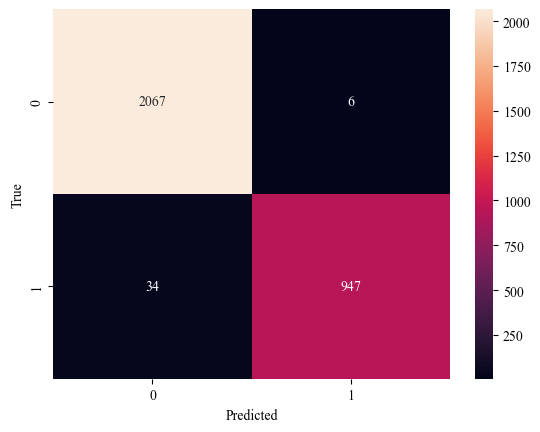

In [124]:
#calcualte confusion matrix at 0.5 threshold
threshold = 0.5
y_pred_thresholded = (y_pred > threshold).astype(int)
conf_matrix = confusion_matrix(y_true, y_pred_thresholded)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
F1 = 2 * precision * recall / (precision + recall)
conf_matrix, precision, recall, F1
TP,FP,FN,TN = conf_matrix[1,1],conf_matrix[0,1],conf_matrix[1,0],conf_matrix[0,0]
print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
# plot graph of confusion matrix 
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

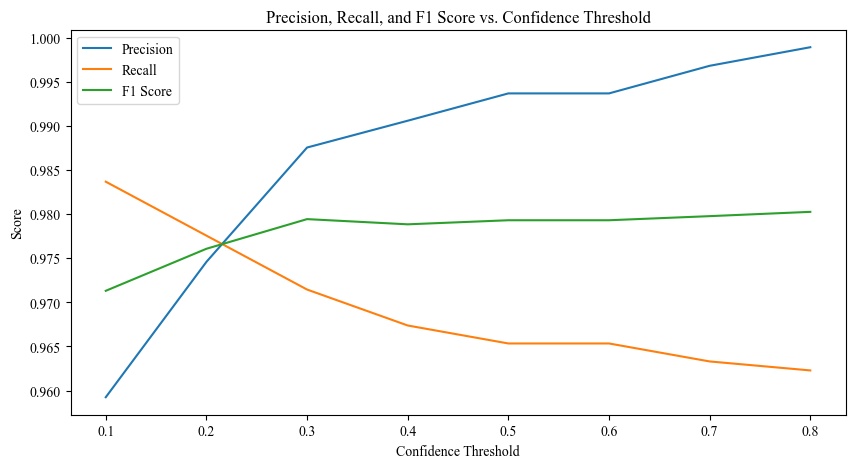

In [128]:
# plot the precision, recall and F1 score curves
plt.figure(figsize=(10, 5))
plt.plot(confidence_thresholds, precision_scores, label="Precision")
plt.plot(confidence_thresholds, recall_scores, label="Recall")
plt.plot(confidence_thresholds, F1_scores, label="F1 Score")
plt.xlabel("Confidence Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision, Recall, and F1 Score vs. Confidence Threshold")
plt.show()